# Data Loading and Preprocessing

In [ ]:
import os
import pandas as pd
import kagglehub
import zipfile

# Step 1: Download the dataset using kagglehub
path = kagglehub.dataset_download("netflix-inc/netflix-prize-data")
print("Path to dataset files:", path)

# Step 2: Verify the downloaded files
files = os.listdir(path)
print("Files in the dataset:", files)

Path to dataset files: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2
Files in the dataset: ['probe.txt', 'combined_data_4.txt', 'qualifying.txt', 'README', 'combined_data_3.txt', 'movie_titles.csv', 'combined_data_2.txt', 'combined_data_1.txt']


In [ ]:
# Define file paths for all combined_data files
file_paths = [
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_1.txt",
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_2.txt",
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_3.txt",
    "/root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_4.txt"
]

def process_single_file(file_path):
    """
    Processes a single combined_data file and returns a DataFrame.

    Args:
        file_path (str): Path to the combined_data file.

    Returns:
        pd.DataFrame: A DataFrame containing the file's data.
    """
    rows = []
    current_movie_id = None

    # Read the file line by line
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()  # Remove extra whitespace
            if line.endswith(':'):
                # Movie ID line
                current_movie_id = int(line[:-1])  # Remove ':' and convert to int
            else:
                # CustomerID, Rating, Date line
                customer_id, rating, date = line.split(',')
                rows.append([current_movie_id, int(customer_id), int(rating), date])

    # Convert rows to a DataFrame
    df = pd.DataFrame(rows, columns=['MovieID', 'CustomerID', 'Rating', 'Date'])
    return df

def combine_files(file_paths):
    """
    Combines data from multiple combined_data files.

    Args:
        file_paths (list): List of file paths to combine.

    Returns:
        pd.DataFrame: A single combined DataFrame.
    """
    data_frames = []

    for file_path in file_paths:
        print(f"Processing file: {file_path}")
        df = process_single_file(file_path)
        data_frames.append(df)

    # Concatenate all DataFrames
    combined_data = pd.concat(data_frames, ignore_index=True)
    return combined_data

# Combine all four combined_data files
combined_data = combine_files(file_paths)

# Display basic information about the combined data
print("Combined Data Overview:")
print(combined_data.info())
print(combined_data.head())


Processing file: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_1.txt
Processing file: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_2.txt
Processing file: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_3.txt
Processing file: /root/.cache/kagglehub/datasets/netflix-inc/netflix-prize-data/versions/2/combined_data_4.txt
Combined Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     int64 
 1   CustomerID  int64 
 2   Rating      int64 
 3   Date        object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB
None
   MovieID  CustomerID  Rating        Date
0        1     1488844       3  2005-09-06
1        1      822109       5  2005-05-13
2        1      885013       4  2005-10-19
3        1       30878       4  2005-12-26
4 

In [ ]:
import os
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive', force_remount=True)

# Check if the directory exists
directory = '/content/drive/My Drive/Colab Notebooks'
if not os.path.exists(directory):
    os.makedirs(directory)  # Create the directory if it doesn't exist
    print(f"Directory created: {directory}")
else:
    print(f"Directory already exists: {directory}")



# Save the combined data to a CSV file
output_file = '/content/drive/My Drive/Colab Notebooks/combined_data_all.csv'
# Combined data has columns: ['MovieID', 'CustomerID', 'Rating', 'Date']
combined_data.to_csv(output_file, index=False)
combined_data = pd.read_csv(output_file, names=["MovieID", "CustomerID", "Rating", "Date"], header=0)

print(f"Combined data saved to {output_file}.")


Mounted at /content/drive
Directory already exists: /content/drive/My Drive/Colab Notebooks
Combined data saved to /content/drive/My Drive/Colab Notebooks/combined_data_all.csv.


# Data Features Engineering



*   The Data Features Engineering cell is corresponding to section 3 (Dataset and Features) in our paper.
*   we have four parts in the following cell : preprocessing, features extracted, data splits, data storage.





In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds

# Mount Google Drive for loading and saving data files
drive.mount('/content/drive', force_remount=True)
# Path to the Netflix Prize dataset
output_file = '/content/drive/My Drive/Colab Notebooks/combined_data_all.csv'

# Step 1: Preprocessing



# 1.1 Normalize Ratings
# Load the dataset with columns: MovieID, CustomerID, Rating, and Date
combined_data = pd.read_csv(output_file, names=["MovieID", "CustomerID", "Rating", "Date"], header=0, low_memory=False)
# Ensure the Rating column is numeric; convert invalid entries to NaN
combined_data['Rating'] = pd.to_numeric(combined_data['Rating'], errors='coerce')

## error checking
print(f"Total rows in combined_data: {len(combined_data)}")
print(combined_data.head())
print(combined_data.info())

# Drop rows with missing or invalid ratings
combined_data = combined_data.dropna(subset=['Rating'])

# Convert the Rating column to a GPU array using CuPy for fast computation
ratings_gpu = cp.array(combined_data['Rating'].values, dtype=cp.float32)

# Compute the global mean rating using GPU acceleration
global_mean = cp.mean(ratings_gpu).get()
# Normalize ratings by subtracting the global mean to reduce user bias
combined_data['NormalizedRating'] = combined_data['Rating'] - global_mean






# 1.2 Filter Users and Movies
# Calculate the number of ratings for each user and movie
user_counts = combined_data['CustomerID'].value_counts()
movie_counts = combined_data['MovieID'].value_counts()

# Debugging information to check filtering thresholds
print(f"Number of users: {len(user_counts)}")
print(f"Users with at least 10 ratings: {sum(user_counts >= 10)}")
print(f"Number of movies: {len(movie_counts)}")
print(f"Movies with at least 5 ratings: {sum(movie_counts >= 5)}")

# Identify low-activity users and low-rated movies
low_activity_users = user_counts[user_counts < 10].index
low_rated_movies = movie_counts[movie_counts < 5].index

# Filter users with fewer than 10 ratings
# All the movies except one has at least 10 ratings, so no further filter for movie
filtered_data = combined_data[
    combined_data['CustomerID'].isin(user_counts[user_counts >= 10].index)
]





# 1.3 Transform Dates
# Convert the Date column to a datetime format
filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])

# Calculate the number of days since the earliest rating for each row
filtered_data['DaysSinceFirstRating'] = (filtered_data['Date'] - filtered_data['Date'].min()).dt.days
# Remove the original Date column after transformation
filtered_data.drop(columns=['Date'], inplace=True)






# Step 2: Feature Engineering
# 2.1 Calculate User and Movie Mean Ratings
# the User mean rating and movie mean rating are new features included
# Compute the mean normalized rating for each user and movie
user_avg_ratings = filtered_data.groupby('CustomerID')['NormalizedRating'].mean()
movie_avg_ratings = filtered_data.groupby('MovieID')['NormalizedRating'].mean()
# Map the mean ratings back to the dataset as new features
filtered_data['UserMeanRating'] = filtered_data['CustomerID'].map(user_avg_ratings)
filtered_data['MovieMeanRating'] = filtered_data['MovieID'].map(movie_avg_ratings)

# Ensure filtered_data is not empty after preprocessing
if filtered_data.empty:
    raise ValueError("Filtered data is empty. Please check filtering conditions or input data.")

# Debugging information to confirm data size
print(f"Filtered data size: {filtered_data.shape[0]} rows")

# Ensure that the DaysSinceFirstRating column is populated
if filtered_data[['DaysSinceFirstRating']].shape[0] == 0:
    raise ValueError("No data available for temporal bucketing.")




# 2.2 Temporal Bucketing
# Discretize DaysSinceFirstRating into 10 equal-width buckets for temporal analysis
discret = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')

filtered_data['DaysSinceFirstRatingBucket'] = discret.fit_transform(
    filtered_data[['DaysSinceFirstRating']]
).astype(int)







# Step 3: Splitting the Data
# Training: 80%, Validation: 10%, Testing: 10%
train_data, temp_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)









# Step 4: Matrix Conversion
# Encode users and movies into numerical indices for efficient matrix operations
train_data['UserEncoded'] = train_data['CustomerID'].astype('category').cat.codes
train_data['MovieEncoded'] = train_data['MovieID'].astype('category').cat.codes

# Apply same encoding for validation and test sets
val_data['UserEncoded'] = val_data['CustomerID'].astype('category').cat.codes
val_data['MovieEncoded'] = val_data['MovieID'].astype('category').cat.codes
test_data['UserEncoded'] = test_data['CustomerID'].astype('category').cat.codes
test_data['MovieEncoded'] = test_data['MovieID'].astype('category').cat.codes


# 4.1 User-Movie Interaction Matrix
# Convert data into arrays for matrix factorization
# Convert data to CuPy arrays
customer_ids = cp.array(filtered_data['CustomerID'].astype('category').cat.codes)
movie_ids = cp.array(filtered_data['MovieID'].astype('category').cat.codes)
normalized_ratings = cp.array(filtered_data['NormalizedRating'])

# Create a sparse interaction matrix
# Convert to scalar integers using .item()
num_customers = customer_ids.max().item() + 1
num_movies = movie_ids.max().item() + 1

# Create a sparse matrix for interactions
interaction_matrix_gpu = csr_matrix((normalized_ratings, (customer_ids, movie_ids)),
                                    shape=(customer_ids.max() + 1, movie_ids.max() + 1))



# 4.2 Perform SVD (Singular Value Decomposition)
# Decompose the interaction matrix into latent features for users and movies
# Perform SVD with CuPy
u, s, vt = svds(interaction_matrix_gpu, k=2)  # Top 4 latent features

# Convert latent features to NumPy arrays for further processing
latent_features = cp.asnumpy(u)  # Use u for user latent features
latent_features_df = pd.DataFrame(latent_features)# Create DataFrames for latent features
latent_features_df['CustomerID'] = filtered_data['CustomerID'].astype('category').cat.categories

movie_latent_features = cp.asnumpy(vt.T)  # Use vt for Movie latent features
movie_latent_features_df = pd.DataFrame(movie_latent_features)
movie_latent_features_df['MovieID'] = filtered_data['MovieID'].astype('category').cat.categories

# Reset the index for merging
latent_features_df.reset_index(drop=True, inplace=True)

# Merge latent features back into training, validation, and testing datasets
train_data = train_data.merge(latent_features_df, on='CustomerID', how='left')
val_data = val_data.merge(latent_features_df, on='CustomerID', how='left')
test_data = test_data.merge(latent_features_df, on='CustomerID', how='left')
train_data = train_data.merge(movie_latent_features_df, on='MovieID', how='left')
val_data = val_data.merge(movie_latent_features_df, on='MovieID', how='left')
test_data = test_data.merge(movie_latent_features_df, on='MovieID', how='left')

# Fill missing latent feature values with 0
train_data.fillna(0, inplace=True)
val_data.fillna(0, inplace=True)
test_data.fillna(0, inplace=True)


# Reapply UserEncoded and MovieEncoded after merging
train_data['UserEncoded'] = train_data['CustomerID'].astype('category').cat.codes
train_data['MovieEncoded'] = train_data['MovieID'].astype('category').cat.codes

val_data['UserEncoded'] = val_data['CustomerID'].astype('category').cat.codes
val_data['MovieEncoded'] = val_data['MovieID'].astype('category').cat.codes

test_data['UserEncoded'] = test_data['CustomerID'].astype('category').cat.codes
test_data['MovieEncoded'] = test_data['MovieID'].astype('category').cat.codes

# Define latent feature columns
"""
Index(['MovieID', 'CustomerID', 'Rating', 'NormalizedRating',
       'DaysSinceFirstRating', 'UserMeanRating', 'MovieMeanRating',
       'DaysSinceFirstRatingBucket', '0_x', '1_x', '0_y', '1_y', 'UserEncoded',
       'MovieEncoded'],
      dtype='object')
train data columns above
"""
latent_feature_cols = ['0_x', '1_x', '0_y', '1_y']











# Step 5: Define Features and Targets
X_train = train_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                      'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
X_val = val_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                  'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
X_test = test_data[['UserEncoded', 'MovieEncoded', 'DaysSinceFirstRating',
                    'UserMeanRating', 'MovieMeanRating', 'DaysSinceFirstRatingBucket'] + latent_feature_cols]
# 5.1: Create interaction terms
# we create the interaction terms because their might exist internal relationship between latent_features.
for i, user_col in enumerate(latent_feature_cols[:2]):  # User latent features are the first two columns
    for j, movie_col in enumerate(latent_feature_cols[2:]):  # Movie latent features are the last two columns
        X_train[f'interaction_{i}_{j}'] = X_train[user_col] * X_train[movie_col]
        X_val[f'interaction_{i}_{j}'] = X_val[user_col] * X_val[movie_col]
        X_test[f'interaction_{i}_{j}'] = X_test[user_col] * X_test[movie_col]


# Extract the response variables.
y_train = train_data['NormalizedRating']
y_val = val_data['NormalizedRating']
y_test = test_data['NormalizedRating']

# Fill missing values with 0
X_train.fillna(0, inplace=True)
X_val.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

# Since each time processing data feature engineering requires at least an hour,
# we directly store the data and no longer need to redo the above data feature engineering part once offline
# Here, it need google drive at least 100 GB storage
X_train.to_csv('/content/drive/My Drive/Colab Notebooks/X_train.csv', index=False)
X_val.to_csv('/content/drive/My Drive/Colab Notebooks/X_val.csv', index=False)
X_test.to_csv('/content/drive/My Drive/Colab Notebooks/X_test.csv', index=False)

y_train.to_csv('/content/drive/My Drive/Colab Notebooks/y_train.csv', index=False)
y_val.to_csv('/content/drive/My Drive/Colab Notebooks/y_val.csv', index=False)
y_test.to_csv('/content/drive/My Drive/Colab Notebooks/y_test.csv', index=False)
print("Datasets saved successfully!")


Mounted at /content/drive
Total rows in combined_data: 100480507
   MovieID  CustomerID  Rating        Date
0        1     1488844       3  2005-09-06
1        1      822109       5  2005-05-13
2        1      885013       4  2005-10-19
3        1       30878       4  2005-12-26
4        1      823519       3  2004-05-03
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100480507 entries, 0 to 100480506
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   MovieID     int64 
 1   CustomerID  int64 
 2   Rating      int64 
 3   Date        object
dtypes: int64(3), object(1)
memory usage: 3.0+ GB
None
Number of users: 480189
Users with at least 10 ratings: 463770
Number of movies: 17770
Movies with at least 5 ratings: 17769


<ipython-input-3-ea832b8c194a>:65: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['Date'] = pd.to_datetime(filtered_data['Date'])
<ipython-input-3-ea832b8c194a>:66: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DaysSinceFirstRating'] = (filtered_data['Date'] - filtered_data['Date'].min()).dt.days
<ipython-input-3-ea832b8c194a>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

Filtered data size: 100396384 rows


<ipython-input-3-ea832b8c194a>:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['DaysSinceFirstRatingBucket'] = discretizer.fit_transform(
<ipython-input-3-ea832b8c194a>:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[f'interaction_{i}_{j}'] = X_train[user_col] * X_train[movie_col]
<ipython-input-3-ea832b8c194a>:195: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

Datasets saved successfully!


## Load the partition data.

In [ ]:
# Load the datasets from Google Drive if you are offline.
# No longer need to do the feature engineering part again.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds
# Reload the data back once offline.
X_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_train.csv')
X_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_val.csv')
X_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/X_test.csv')

y_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_train.csv')
y_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_val.csv')
y_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/y_test.csv')

print("Datasets loaded successfully!")

Datasets loaded successfully!


# Machine Learning Engineering


This project explores methods to predict Netflix movie ratings. We employ the following models:

1. **Linear Regression with SVD Features**
    - Utilizes Singular Value Decomposition (SVD) to extract latent features from the user-movie interaction matrix.

2. **Ridge Regression**
    - Adds regularization to mitigate overfitting in rating predictions.

3. **Temporal Matrix Factorization (TMF)**
    - Captures temporal dynamics by modeling user and movie preferences over time.

4. **XGBoost**
    - Leverages gradient-boosted decision trees for flexible and robust predictive performance.

### Cold-Start Problem with BPR

To address the cold-start problem, we integrate **Bayesian Personalized Ranking (BPR)**. This approach evaluates how effectively the system can recommend the top 10 highest-rated movies for new users entering the platform.





## Linear Regression + SVD Features




In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
# 4.2.1 Linear regression
reg = LinearRegression()
reg.fit(X_train, y_train)
# Step 1: Training Accuracy
y_train_pred = reg.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
print("Experiement result for Linear Regression + SVD Features")
print("Training RMSE:", train_rmse)

# Step 2: Validation Accuracy
y_val_pred = reg.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
val_rmse = np.sqrt(val_mse)
print("Validation RMSE:", val_rmse)

# Step 3: Test Accuracy
y_test_pred = reg.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
print("Test RMSE:", test_rmse)


Experiement result for Linear Regression + SVD Features
Training RMSE: 0.9051700746569552
Validation RMSE: 0.9048902594688573
Test RMSE: 0.9052695350111042


## Ridge Regression Implementation


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import numpy as np
# 4.2.2 Ridge regression.
# Define a range of alpha values to test
alpha_values = [0.01, 0.1, 1, 10, 100]

# Store results for analysis
results = []


for alpha in alpha_values:
    # Initialize Ridge Regressor with the current alpha
    ridge_regressor = Ridge(alpha=alpha)

    # Train the Ridge model
    ridge_regressor.fit(X_train, y_train)

    # Predictions
    y_train_pred = ridge_regressor.predict(X_train)
    y_val_pred = ridge_regressor.predict(X_val)
    y_test_pred = ridge_regressor.predict(X_test)

    # Compute RMSE
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    # Append results
    results.append({
        'alpha': alpha,
        'train_rmse': train_rmse,
        'val_rmse': val_rmse,
        'test_rmse': test_rmse,

    })
    print(f"Alpha: {alpha}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}, Test RMSE: {test_rmse:.4f}")

# Find the best alpha based on validation RMSE
best_result = min(results, key=lambda x: x['val_rmse'])
print("\nBest Alpha and Results:")
print(f"Alpha: {best_result['alpha']}")
print(f"Train RMSE: {best_result['train_rmse']:.4f}, Val RMSE: {best_result['val_rmse']:.4f}, Test RMSE: {best_result['test_rmse']:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=5.10611e-20): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.01, Train RMSE: 0.9179, Val RMSE: 0.9177, Test RMSE: 0.9180


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.09119e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 0.1, Train RMSE: 0.9185, Val RMSE: 0.9183, Test RMSE: 0.9186


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=7.00386e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 1, Train RMSE: 0.9215, Val RMSE: 0.9212, Test RMSE: 0.9216


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.82671e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 10, Train RMSE: 0.9229, Val RMSE: 0.9226, Test RMSE: 0.9230


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.85961e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Alpha: 100, Train RMSE: 0.9231, Val RMSE: 0.9229, Test RMSE: 0.9232

Best Alpha and Results:
Alpha: 0.01
Train RMSE: 0.9179, Val RMSE: 0.9177, Test RMSE: 0.9180


## Matrix Factorization with Temporal Dynamics

In [ ]:
import numpy as np
import cupy as cp
from sklearn.metrics import mean_squared_error
# 4.2.3 Temporal Matrix Factorization (TMF)
# Function to train a Temporal Matrix Factorization model with batch processing
def TMF(data, num_factors, learning_rate, num_epochs, lambda_reg, batch_size, patience=2):
  """
    Trains a Temporal Matrix Factorization model using SGD with batch processing.

    Parameters:
        data: DataFrame containing training data with 'UserEncoded', 'MovieEncoded', 'DaysSinceFirstRatingBucket', and 'NormalizedRating'.
        num_factors: Number of latent factors for users and movies.
        learning_rate: Learning rate for gradient updates.
        num_epochs: Maximum number of training epochs.
        lambda_reg: Regularization term to prevent overfitting.
        batch_size: Number of samples per training batch.
        patience: Number of epochs to wait for improvement before early stopping.

    Returns:
        user_latent_matrix, movie_latent_matrix: Learned user and movie latent factor matrices.
        user_time_bias, movie_time_bias: Learned user and movie time biases.
    """
    # Initialization of parameters
    num_users = data['UserEncoded'].max() + 1
    num_movies = data['MovieEncoded'].max() + 1
    num_buckets = data['DaysSinceFirstRatingBucket'].max() + 1

    # Random initialization of user and movie latent factor matrices
    user_latent_matrix = cp.random.normal(scale=0.1, size=(num_users, num_factors), dtype=cp.float32)
    movie_latent_matrix = cp.random.normal(scale=0.1, size=(num_movies, num_factors), dtype=cp.float32)
    # Initialize time biases for users and movies
    user_time_bias = cp.zeros((num_users, num_buckets), dtype=cp.float32)
    movie_time_bias = cp.zeros((num_movies, num_buckets), dtype=cp.float32)
    # Calculate global mean rating
    global_mean = y_train['NormalizedRating'].mean()

    # Convert data columns to GPU arrays for computation
    user_idx = cp.array(data['UserEncoded'].values)
    movie_idx = cp.array(data['MovieEncoded'].values)
    bucket_idx = cp.array(data['DaysSinceFirstRatingBucket'].values)
    ratings = cp.array(y_train['NormalizedRating'].values)

    # Variables to track best loss for early stopping
    best_loss = float('inf')
    early_stop_count = 0

    # Training loop
    for epoch in range(num_epochs):
      # Shuffle the data for each epoch
        shuffled_indices = cp.random.permutation(len(data))
        user_idx = user_idx[shuffled_indices]
        movie_idx = movie_idx[shuffled_indices]
        bucket_idx = bucket_idx[shuffled_indices]
        ratings = ratings[shuffled_indices]

        epoch_loss = 0 # Accumulator for loss during the epoch

        # Process data in batches
        for start in range(0, len(data), batch_size):
            end = start + batch_size
            batch_user_idx = user_idx[start:end]
            batch_movie_idx = movie_idx[start:end]
            batch_bucket_idx = bucket_idx[start:end]
            batch_ratings = ratings[start:end]

            # Compute predicted ratings using current parameters
            user_latents = user_latent_matrix[batch_user_idx]
            movie_latents = movie_latent_matrix[batch_movie_idx]
            predicted_ratings = global_mean + \
                user_time_bias[batch_user_idx, batch_bucket_idx] + \
                movie_time_bias[batch_movie_idx, batch_bucket_idx] + \
                cp.einsum('ij,ij->i', user_latents, movie_latents)

            # Compute prediction errors
            errors = batch_ratings - predicted_ratings

            # Update biases for users and movies
            cp.add.at(user_time_bias, (batch_user_idx, batch_bucket_idx),
                      learning_rate * (errors - lambda_reg * user_time_bias[batch_user_idx, batch_bucket_idx]))
            cp.add.at(movie_time_bias, (batch_movie_idx, batch_bucket_idx),
                      learning_rate * (errors - lambda_reg * movie_time_bias[batch_movie_idx, batch_bucket_idx]))

            # Compute gradients for user and movie latent factors
            grad_user = learning_rate * (errors[:, None] * movie_latents - lambda_reg * user_latents)
            grad_movie = learning_rate * (errors[:, None] * user_latents - lambda_reg * movie_latents)

            # Gradient clipping to avoid exploding gradients
            cp.clip(grad_user, -2, 2, out=grad_user)
            cp.clip(grad_movie, -2, 2, out=grad_movie)

            # Update latent factors
            user_latent_matrix[batch_user_idx] += grad_user
            movie_latent_matrix[batch_movie_idx] += grad_movie

            # Accumulate batch loss
            batch_loss = cp.mean(errors**2)
            epoch_loss += batch_loss

        # Compute epoch loss and add regularization penalty
        epoch_loss = epoch_loss / (len(data) // batch_size)
        epoch_loss += lambda_reg * (
            cp.linalg.norm(user_latent_matrix)**2 + cp.linalg.norm(movie_latent_matrix)**2
        )

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss.get():.4f}")

        # Early stopping logic
        # oour patience is 2, once the training loss does not decrease for more than 2 times
        # we stop
        if epoch_loss.get() < best_loss:
            best_loss = epoch_loss.get()
            early_stop_count = 0
            # Save the best parameters for later testing and validation
            best_user_latent_matrix = user_latent_matrix.copy()
            best_movie_latent_matrix = movie_latent_matrix.copy()
            best_user_time_bias = user_time_bias.copy()
            best_movie_time_bias = movie_time_bias.copy()
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

    print(f"Best Loss: {best_loss:.4f}")
    return user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias


# Function to evaluate the trained model
def evaluate_model(data, y_normal, user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias, global_mean):
  """
    Evaluates the Temporal Matrix Factorization model using RMSE.

    Parameters:
        data: DataFrame containing evaluation data.
        y_normal: DataFrame with normalized ratings.
        user_latent_matrix, movie_latent_matrix: Latent factor matrices from training.
        user_time_bias, movie_time_bias: Time biases from training.
        global_mean: Mean of the training ratings.

    Returns:
        RMSE value for the given dataset.
    """
    # Convert data columns to GPU arrays for evaluation
    user_idx = cp.array(data['UserEncoded'].values)
    movie_idx = cp.array(data['MovieEncoded'].values)
    bucket_idx = cp.array(data['DaysSinceFirstRatingBucket'].values)
    ratings = cp.array(y_normal['NormalizedRating'].values)

     # Compute predicted ratings
    user_latents = user_latent_matrix[user_idx]
    movie_latents = movie_latent_matrix[movie_idx]
    predicted_ratings = global_mean + \
        user_time_bias[user_idx, bucket_idx] + \
        movie_time_bias[movie_idx, bucket_idx] + \
        cp.einsum('ij,ij->i', user_latents, movie_latents)

    # Compute RMSE
    mse = mean_squared_error(cp.asnumpy(ratings), cp.asnumpy(predicted_ratings))
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

# Hyper parameters tunning
num_factors = 15
learning_rate = 0.1
num_epochs = 20
lambda_reg = 0.3
batch_size = 1024
patience = 2  # Early stopping patience

train_data = X_train
val_data = X_val
test_data = X_test
y_train_normal = y_train
y_val_normal = y_val
y_test_normal = y_test


user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias = TMF(
    train_data, num_factors, learning_rate, num_epochs, lambda_reg, batch_size, patience
)

global_mean = y_train['NormalizedRating'].mean()
print("Training Set Evaluation:")
train_rmse = evaluate_model(train_data, y_train_normal, user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias, global_mean)
print(f"Train RMSE: {train_rmse:.4f}")
# Evaluate on Validation and Test Sets
print("Validation Set Evaluation:")
val_rmse = evaluate_model(val_data, y_val_normal, user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias, global_mean)
print(f"Validation RMSE: {val_rmse:.4f}")

print("Test Set Evaluation:")
test_rmse = evaluate_model(test_data, y_test_normal, user_latent_matrix, movie_latent_matrix, user_time_bias, movie_time_bias, global_mean)
print(f"Test RMSE: {test_rmse:.4f}")



Epoch 1/20, Loss: 1936.8648
Epoch 2/20, Loss: 643.7501
Epoch 3/20, Loss: 269.7832
Epoch 4/20, Loss: 127.1088
Epoch 5/20, Loss: 64.5522
Epoch 6/20, Loss: 34.6731
Epoch 7/20, Loss: 19.5223
Epoch 8/20, Loss: 11.4945
Epoch 9/20, Loss: 7.0891
Epoch 10/20, Loss: 4.5997
Epoch 11/20, Loss: 3.1587
Epoch 12/20, Loss: 2.3058
Epoch 13/20, Loss: 1.7915
Epoch 14/20, Loss: 1.4756
Epoch 15/20, Loss: 1.2787
Epoch 16/20, Loss: 1.1537
Epoch 17/20, Loss: 1.0733
Epoch 18/20, Loss: 1.0208
Epoch 19/20, Loss: 0.9862
Epoch 20/20, Loss: 0.9628
Best Loss: 0.9628
Training Set Evaluation:
RMSE: 0.9438
Train RMSE: 0.9438
Validation Set Evaluation:
RMSE: 1.1763
Validation RMSE: 1.1763
Test Set Evaluation:
RMSE: 1.1883
Test RMSE: 1.1883


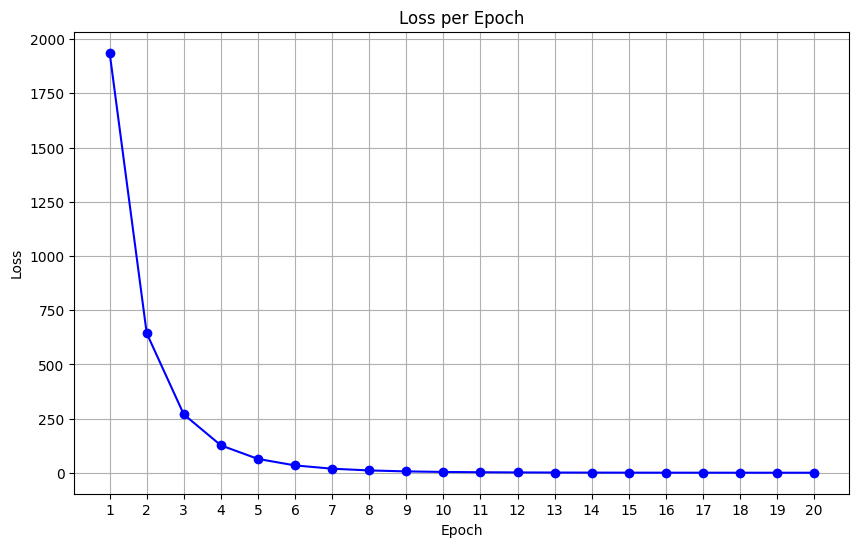

In [ ]:
import matplotlib.pyplot as plt

# Loss values for each epoch
epochs = list(range(1, 21))
loss_values = [
    1936.8648, 643.7501, 269.7832, 127.1088, 64.5522, 34.6731, 19.5223,
    11.4945, 7.0891, 4.5997, 3.1587, 2.3058, 1.7915, 1.4756, 1.2787,
    1.1537, 1.0733, 1.0208, 0.9862, 0.9628
]

# Plot the loss graph
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.grid(True)
plt.show()


## BPR Bayesian Personalized Ranking

*  We add the BPR model becuase we mention it in draft report's introduction, but does not actually implement in draft report.

*   Noting that the BPR problem is seperate with the above models, it only handle for the cold start problem

*   the result in last cell mean if we choose 10 movies for the new user(cold - start), the system accuracy to recommend 10 high rating movie is 0.8345

### Redo the feature extraction and Engineering

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds

# Load the dataset if offline
# Here we do not need any further interaction features as well as matrix factorization feature
# In that case, we re-do the data feature part, this would help our training process for BPR quicker
drive.mount('/content/drive', force_remount=True)
output_file = '/content/drive/My Drive/Colab Notebooks/combined_data_all.csv'
combined_data = pd.read_csv(output_file, names=["MovieID", "CustomerID", "Rating", "Date"], header=0, low_memory=False)

# Ensure numeric ratings
combined_data['Rating'] = pd.to_numeric(combined_data['Rating'], errors='coerce')
combined_data.dropna(subset=['Rating'], inplace=True)

# Filter active users and movies
user_counts = combined_data['CustomerID'].value_counts()
movie_counts = combined_data['MovieID'].value_counts()

filtered_data = combined_data[
    combined_data['CustomerID'].isin(user_counts[user_counts >= 10].index)
]

# Split data into train, validation, and test sets
train_data_bpr, temp_data = train_test_split(filtered_data, test_size=0.2, random_state=42)
val_data_bpr, test_data_bpr = train_test_split(temp_data, test_size=0.5, random_state=42)

# Save processed datasets
# Easy to use if offline
train_data_bpr.to_csv('/content/drive/My Drive/Colab Notebooks/train_data_simple_bpr.csv', index=False)
val_data_bpr.to_csv('/content/drive/My Drive/Colab Notebooks/val_data_simple_bpr.csv', index=False)
test_data_bpr.to_csv('/content/drive/My Drive/Colab Notebooks/test_data_simple_bpr.csv', index=False)

print("Feature engineering completed. Data saved.")


Mounted at /content/drive
Feature engineering completed. Data saved.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.decomposition import TruncatedSVD
import cupy as cp
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import os
from google.colab import drive
from cupyx.scipy.sparse import csr_matrix
from cupyx.scipy.sparse.linalg import svds
# If you are offline for the project but want to do the BPR testing, directly run this cell to recover data
# Mount Google Drive to access data files stored in the user's Drive account
drive.mount('/content/drive', force_remount=True)

# Path to the combined dataset file
output_file = '/content/drive/My Drive/Colab Notebooks/combined_data_all.csv'

# Load the combined dataset
# Dataset contains columns: MovieID, CustomerID, Rating, and Date
combined_data = pd.read_csv(output_file, names=["MovieID", "CustomerID", "Rating", "Date"],
                             header=0, low_memory=False)

# Reload preprocessed training, validation, and test datasets with raw ratings
train_data_bpr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/train_data_simple_bpr.csv')
val_data_bpr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/val_data_simple_bpr.csv')
test_data_bpr = pd.read_csv('/content/drive/My Drive/Colab Notebooks/test_data_simple_bpr.csv')

# Calculate thresholds for positive and negative ratings
# using the thresholds is better than arbitry choose the rating number for good or bad movie
# These thresholds are derived based on the 75th and 25th percentiles of the ratings
rating_75th = combined_data['Rating'].quantile(0.75)  # Threshold for positive interactions
rating_25th = combined_data['Rating'].quantile(0.25)  # Threshold for negative interactions

# Print thresholds for debugging and verification
print(f"Positive Threshold: >{rating_75th}")  # Ratings above this are considered positive
print(f"Negative Threshold: <{rating_25th}")  # Ratings below this are considered negative


# Function to generate interaction labels (positive, negative, neutral) based on thresholds
def generate_interaction_labels(data, pos_threshold, neg_threshold):
    """
    Generate interaction labels for the given dataset based on rating thresholds.

    Parameters:
        data (DataFrame): The input dataset containing a 'Rating' column.
        pos_threshold (float): The minimum rating value to classify as positive interaction.
        neg_threshold (float): The maximum rating value to classify as negative interaction.

    Returns:
        Series: Interaction labels (1 for positive, -1 for negative, 0 for neutral).
    """
    # Initialize all interactions as neutral (0)
    interactions = pd.Series(0, index=data.index)

    # Assign positive interaction label (1) for ratings above the positive threshold
    interactions[data['Rating'] > pos_threshold] = 1

    # Assign negative interaction label (-1) for ratings below the negative threshold
    interactions[data['Rating'] < neg_threshold] = -1

    return interactions

# Generate interaction labels for the training, validation, and test datasets
# Using the calculated thresholds for positive and negative interactions
y_train_interactions = generate_interaction_labels(train_data_bpr, rating_75th, rating_25th)
y_val_interactions = generate_interaction_labels(val_data_bpr, rating_75th, rating_25th)
y_test_interactions = generate_interaction_labels(test_data_bpr, rating_75th, rating_25th)

# At this point:
# y_train_interactions, y_val_interactions, and y_test_interactions contain interaction labels
# These labels will be used for generating BPR (Bayesian Personalized Ranking) training pairs


Mounted at /content/drive
Positive Threshold: >4.0
Negative Threshold: <3.0


In [ ]:
import random
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np

# Define BCE Loss
# Binary Cross Entropy with Logits Loss for training the BPR model
crt = nn.BCEWithLogitsLoss()

# Create mappings for zero-based indexing
def Mapping(train_data):
  """
    Create mappings for users and movies to unique zero-based indices.
    These mappings are essential for encoding categorical IDs into numerical indices for embeddings.

    Args:
        train_data (DataFrame): Training dataset containing CustomerID and MovieID.

    Returns:
        user_mapping (dict): Mapping of unique CustomerID to zero-based indices.
        movie_mapping (dict): Mapping of unique MovieID to zero-based indices.
    """
    user_mapping = {user_id: idx for idx, user_id in enumerate(train_data['CustomerID'].unique())}
    movie_mapping = {movie_id: idx for idx, movie_id in enumerate(train_data['MovieID'].unique())}
    return user_mapping, movie_mapping

# Generate BPR pairs using UserEncoded and MovieEncoded
def apply_mappings(data, user_mapping, movie_mapping):
  """
    Apply precomputed user and movie mappings to encode CustomerID and MovieID.

    Args:
        data (DataFrame): Dataset containing CustomerID and MovieID.
        user_mapping (dict): Mapping for encoding users.
        movie_mapping (dict): Mapping for encoding movies.

    Returns:
        DataFrame: Dataset with UserEncoded and MovieEncoded columns added.
    """
    data['UserEncoded'] = data['CustomerID'].map(user_mapping)
    data['MovieEncoded'] = data['MovieID'].map(movie_mapping)
    return data

# Generate BPR pairs using UserEncoded and MovieEncoded
def generate_bpr_pairs(data, y_interactions):
  """
    Generate pairs for Bayesian Personalized Ranking (BPR).
    Each pair consists of a user, a positive item (interacted with), and a negative item (not interacted with).

    Args:
        data (DataFrame): Dataset containing UserEncoded and MovieEncoded.
        y_interactions (Series): Interaction labels (1 for positive, -1 for negative).

    Returns:
        List of tuples: Each tuple contains (user, positive_item, negative_item).
    """
    pairs = []
    user_group = data.groupby('UserEncoded')

    for user, group in user_group:
        positive_items = group.loc[y_interactions[group.index] == 1, 'MovieEncoded']
        negative_items = group.loc[y_interactions[group.index] == -1, 'MovieEncoded']

        for pos_item in positive_items:
            if not negative_items.empty:
                neg_item = random.choice(negative_items.tolist())
                pairs.append((user, pos_item, neg_item))

    return pairs

# Define BPR model
class BPRModel(nn.Module):
  """
    BPR Model with user and item embeddings for collaborative filtering.
    """
    def __init__(self, num_users, num_items, embedding_dim):
      """
        Initialize the model with user and item embeddings.

        Args:
            num_users (int): Number of unique users.
            num_items (int): Number of unique items.
            embedding_dim (int): Dimensionality of the embedding vectors.
        """
        super(BPRModel, self).__init__()
        self.user_embeddings = nn.Embedding(num_users, embedding_dim)
        self.item_embeddings = nn.Embedding(num_items, embedding_dim)
        self.init_weights()

    def init_weights(self):
      """
        Initialize embedding weights with a normal distribution for stability in training.
        """
        nn.init.normal_(self.user_embeddings.weight, mean=0.0, std=0.01)
        nn.init.normal_(self.item_embeddings.weight, mean=0.0, std=0.01)

    def forward(self, user, pos_item, neg_item):
      """
        Forward pass to compute scores for positive and negative items.

        Args:
            user (Tensor): Encoded user indices.
            pos_item (Tensor): Encoded positive item indices.
            neg_item (Tensor): Encoded negative item indices.

        Returns:
            Tensor: Positive item scores.
            Tensor: Negative item scores.
        """
        user_emb = self.user_embeddings(user)
        pos_item_emb = self.item_embeddings(pos_item)
        neg_item_emb = self.item_embeddings(neg_item)

        pos_scores = (user_emb * pos_item_emb).sum(dim=1)
        neg_scores = (user_emb * neg_item_emb).sum(dim=1)

        return pos_scores, neg_scores

# Train BPR model with early stopping
def BPR(model, train_pairs, val_pairs, num_epochs, learning_rate, batch_size, patience=3):
  """
    Train the BPR model using SGD with early stopping based on validation loss.

    Args:
        model (BPRModel): BPR model to train.
        train_pairs (list): Training pairs of (user, positive_item, negative_item).
        val_pairs (list): Validation pairs for loss evaluation.
        num_epochs (int): Maximum number of training epochs.
        learning_rate (float): Learning rate for Adam optimizer.
        batch_size (int): Size of mini-batches for training.
        patience (int): Number of epochs to wait for improvement before stopping early.
    """
    opt = Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')
    best_model_state = None
    ep_no_improve = 0

    for epoch in range(num_epochs):
      # Training loop with mini-batches
        random.shuffle(train_pairs)
        losses = []

        for i in range(0, len(train_pairs), batch_size):
            batch = train_pairs[i:i + batch_size]
            users, pos_items, neg_items = zip(*batch)
            users = torch.tensor(users, dtype=torch.long)
            pos_items = torch.tensor(pos_items, dtype=torch.long)
            neg_items = torch.tensor(neg_items, dtype=torch.long)

            pos_scores, neg_scores = model(users, pos_items, neg_items)
            # BCE targets: 1 for positive, 0 for negative

            targets = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).to(pos_scores.device)
            logits = torch.cat([pos_scores, neg_scores])

            loss = crt(logits, targets)

            opt.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            opt.step()

            losses.append(loss.item())

        avg_loss = np.mean(losses)
        print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {avg_loss:.4f}")

        # Validation loss evaluation
        model.eval()
        val_loss = 0

        for user, pos_item, neg_item in val_pairs:
            user = torch.tensor([user], dtype=torch.long)
            pos_item = torch.tensor([pos_item], dtype=torch.long)
            neg_item = torch.tensor([neg_item], dtype=torch.long)

            pos_score, neg_score = model(user, pos_item, neg_item)

            logits = torch.cat([pos_score, neg_score])
            targets = torch.cat([torch.ones(pos_score.size(0)), torch.zeros(neg_score.size(0))]).to(pos_score.device)
            val_loss += crt(logits, targets).item()

        val_loss /= len(val_pairs)
        print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

        # Early stopping mechanism
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_state = model.state_dict()
            ep_no_improve = 0
        else:
            ep_no_improve += 1

        if ep_no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

# Evaluate the model
def evaluate_bpr(model, val_pairs, k=10):
  """
    Evaluate the model using Precision@k by comparing scores of positive and negative items.

    Args:
        model (BPRModel): Trained BPR model.
        val_pairs (list): Validation or test pairs.
        k (int): Top-k ranking precision.

    Returns:
        None: Prints the precision score.
    """
    model.eval()
    hit = 0

    for user, pos_item, neg_item in val_pairs:
        user = torch.tensor([user], dtype=torch.long)
        pos_item = torch.tensor([pos_item], dtype=torch.long)
        neg_item = torch.tensor([neg_item], dtype=torch.long)

        pos_score, neg_score = model(user, pos_item, neg_item)

        if pos_score > neg_score:
            hit += 1

    accuracy = hit / len(val_pairs)
    print(f"Precision@{k}: {accuracy:.4f}")

# Main script
# Create user and movie mappings
user_mapping, movie_mapping = Mapping(train_data_bpr)
# Apply mappings to training, validation, and test data
train_data_bpr = apply_mappings(train_data_bpr, user_mapping, movie_mapping)
val_data_bpr = apply_mappings(val_data_bpr, user_mapping, movie_mapping)
test_data_bpr = apply_mappings(test_data_bpr, user_mapping, movie_mapping)

# Generate training, validation, and test pairs
train_pairs = generate_bpr_pairs(train_data_bpr, y_train_interactions)
val_pairs = generate_bpr_pairs(val_data_bpr, y_val_interactions)
test_pairs = generate_bpr_pairs(test_data_bpr, y_test_interactions)

print(f"Generated {len(train_pairs)} training pairs.")
print(f"Generated {len(val_pairs)} validation pairs.")
print(f"Generated {len(test_pairs)} test pairs.")

# Define model parameters
num_users = train_data_bpr['UserEncoded'].max() + 1
num_items = train_data_bpr['MovieEncoded'].max() + 1
embedding_dim = 50

# Instantiate and train the model
bpr_model = BPRModel(num_users, num_items, embedding_dim)

BPR(bpr_model, train_pairs, val_pairs, num_epochs=10, learning_rate=0.01, batch_size=1024, patience=3)

# Evaluate the model
evaluate_bpr(bpr_model, val_pairs)

Generated 17988776 training pairs.
Generated 1865476 validation pairs.
Generated 1870576 test pairs.
Epoch 1/10, Training Loss: 0.3991
Epoch 1/10, Validation Loss: 0.6955
Epoch 2/10, Training Loss: 0.2522
Epoch 2/10, Validation Loss: 0.9562
Epoch 3/10, Training Loss: 0.2108
Epoch 3/10, Validation Loss: 1.2215
Epoch 4/10, Training Loss: 0.1915
Epoch 4/10, Validation Loss: 1.4689
Early stopping triggered at epoch 4
Precision@10: 0.8345


In [ ]:
# generate pdf
# Please provide the full path of the notebook file below
# Important: make sure that your file name does not contain spaces!

notebookpath = '/content/drive/My Drive/Colab Notebooks/dev_without_xgboost.ipynb'
drive_mount_point = '/content/drive/'
from google.colab import drive
drive.mount(drive_mount_point)
file_name = notebookpath.split('/')[-1]
get_ipython().system("apt update && apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended")
get_ipython().system("pip install pypandoc")
get_ipython().system("apt-get install texlive texlive-xetex texlive-latex-extra pandoc")
get_ipython().system("jupyter nbconvert --to PDF {}".format(notebookpath.replace(' ', '\\ ')))
from google.colab import files
files.download(notebookpath.split('.')[0]+'.pdf')

Mounted at /content/drive/
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,192 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,454 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:11 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,626 kB]
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>